In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import keyedvectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Connect to database

In [ ]:
#Load database
conn = sqlite3.connect('amazon_food_reviews.sqlite')

original_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3""", conn)

original_data.head()

## Data preprocessing

In [ ]:
# Replace number rating with positive and negative strings
print(f'Size after droping duplicates {original_data.size}')
original_data = original_data.drop_duplicates({"UserId", "ProfileName", "Time", "Text"})

original_data["Score"] = original_data["Score"].map(lambda x: "positive" if x > 3 else "negative")
print(f'Size before droping duplicates {original_data.size}')

In [ ]:
original_data = original_data[original_data.HelpfulnessDenominator >= original_data.HelpfulnessNumerator]
print(f'Size after droping Helpfulness denominator greater than Numerator {original_data.size}')

In [ ]:
#Number of positive and negative reviews
original_data["Score"].value_counts()


#### We are concerned only about the Reviews and the score column so extract those in to a new variable

In [ ]:
filtered_data = original_data.loc[:,["Time","Score","Text"]]

np_random_perm = np.random.permutation(30000)

filtered_data = filtered_data[filtered_data.Score == "positive"].iloc[np_random_perm, :]. \
                    append(filtered_data[filtered_data.Score == "negative"].iloc[np_random_perm, :])

filtered_data = filtered_data.sort_values(by=['Time'])

print(filtered_data.shape)
print(filtered_data.isnull().any())
print(filtered_data.head())
print(filtered_data.tail())

## Text preprocessing : Remove Html Tags, Punctuations, alphanumerics and stop words. 

1. Obtain stem words for the remaining words and run algorithm using the data
2. Obtain lemma for each word and run algorithm using the data

In [ ]:
# Code copied from the description python note book

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|-]',r' ',cleaned)
    return  cleaned

#### Clean the reviews

In [ ]:
processed_reviews=[]

for (index, review) in enumerate(filtered_data["Text"].values):
    processedReviewWords = []
    cleanedReview = cleanpunc(cleanhtml(review))
    for word in cleanedReview.split():
        word_in_lowercase = word.lower()
        if(word_in_lowercase.isalpha and \
           (word_in_lowercase not in stop) and \
           len(word_in_lowercase)>2):
            processedReviewWords.append(sno.stem(word_in_lowercase).encode('utf8'))
    processed_reviews.append(b" ".join(processedReviewWords))
    
print(processed_reviews[:5])

#### Append the cleaned text to the table with the normal text

In [ ]:
filtered_data["CleanedText"] = processed_reviews
filtered_data["CleanedText"] = filtered_data["CleanedText"].str.decode("utf-8")
filtered_data.head()

#### Import libraries for Clasification

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
conn = conn = sqlite3.connect('D:\\Studies\\AppliedAi\\AmazonFoodReviews\\Cleaned_Text.sqlite')

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews""", conn)

In [5]:
from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(filtered_data['Score'], classes=['negative','positive']) 
# negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array

## Split data in to train and test

In [6]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(filtered_data["CleanedText"], encoded_labels,\
                                                                     test_size=0.3, random_state=0)

## Common Functions definitions

In [7]:
def ColumnStandardization(train_data, test_data):
    """ Column standardization to get unit variance.
    with_mean is set to false so that it works for sparse matrix
    """
    standardizer = StandardScaler(with_mean=False)
    std_train_data = standardizer.fit_transform(train_data)
    std_test_data = standardizer.transform(test_data)
    return (std_train_data, std_test_data)

In [15]:
def LogisticRegressionClassifier(train_features, train_class, test_features, test_class, X_SearchCV, regularizations=['l2','l1']):
    """
    1. Calculates C value
    2. Plots cross validation erros v/s the alpha values
    3. Plots confusion matrix for the predictions
    """
    
    c_values = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

    models = []
    
    for index, regulaizer in enumerate(regularizations):
        model_tmp = X_SearchCV(LogisticRegression(penalty=regulaizer), c_values, cv=5, \
                                        scoring='accuracy')
        
        models.append(model_tmp)
        
        print(f'-----------------------------{regulaizer}--------------------------------------')
        
        model_tmp.fit(train_features, train_class)
        print(model_tmp.best_estimator_)
        acc = model_tmp.score(test_features, test_class) * float(100)

        predictions = model_tmp.predict(test_features)

        f1 = f1_score(test_class, predictions) * float(100)
        precision = precision_score(test_class, predictions) * float(100)
        recall = recall_score(test_class, predictions) * float(100)

        print(f'Accuracy = {acc}') 
        print(f'F1 Score = {f1}') 
        print(f'Precision = {precision}') 
        print(f'Recall = {recall}') 

        df_cm = pd.DataFrame(data=confusion_matrix(test_class, predictions),index=range(2),columns= ['Negative','Positive'])

        plt.figure(index)
        
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
        
        plt.figure(index + 1)
        
        fpr, tpr, thresholds = roc_curve(test_class, predictions)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        print('---------------------------------------------')
    
    
        
    return models

### Bag Of Words

In [10]:
count_vectorizer = CountVectorizer(ngram_range=(1,3), min_df=5)

#fit and transform train data
bow_X_tr = count_vectorizer.fit_transform(X_train)

# transform test data, note that i am not fitting the vectorizer just transforming the test data
bow_X_test = count_vectorizer.transform(X_test)

(bow_X_tr, bow_X_test) = ColumnStandardization(bow_X_tr, bow_X_test)

print(type(bow_X_tr))
print(f"Shape of final_bigrams : {bow_X_tr.get_shape()}")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<class 'scipy.sparse.csr.csr_matrix'>
Shape of final_bigrams : (42000, 69090)


#### Run Classifier

-----------------------------l2--------------------------------------
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy = 88.25
F1 Score = 88.23496690215276
Precision = 87.64504365123219
Recall = 88.8328853046595


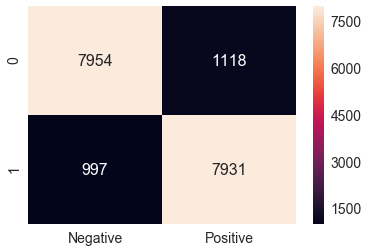

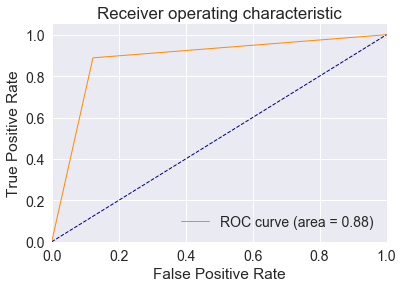

---------------------------------------------
-----------------------------l1--------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy = 88.84444444444445
F1 Score = 88.85063853414769
Precision = 88.0973353886809
Recall = 89.61693548387096


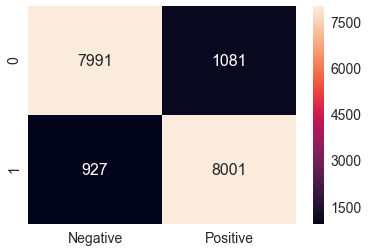

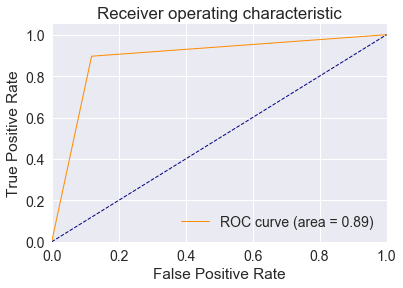

---------------------------------------------


In [16]:
models = LogisticRegressionClassifier(train_features = bow_X_tr, train_class = Y_train, \
                                     test_features = bow_X_test, test_class = Y_test, X_SearchCV = GridSearchCV)

#### How accuracy changes with C for L1 regularization

In [17]:
models[1].grid_scores_

[mean: 0.77602, std: 0.00617, params: {'C': 0.001},
 mean: 0.88250, std: 0.00174, params: {'C': 0.01},
 mean: 0.88012, std: 0.00354, params: {'C': 0.1},
 mean: 0.87688, std: 0.00276, params: {'C': 1},
 mean: 0.87240, std: 0.00386, params: {'C': 10},
 mean: 0.84148, std: 0.00269, params: {'C': 100},
 mean: 0.81826, std: 0.00551, params: {'C': 1000}]

#### How accuracy changes with C for L2 regularization

In [18]:
models[0].grid_scores_

[mean: 0.87974, std: 0.00349, params: {'C': 0.001},
 mean: 0.87055, std: 0.00423, params: {'C': 0.01},
 mean: 0.86495, std: 0.00395, params: {'C': 0.1},
 mean: 0.85317, std: 0.00337, params: {'C': 1},
 mean: 0.81564, std: 0.00608, params: {'C': 10},
 mean: 0.79857, std: 0.00812, params: {'C': 100},
 mean: 0.79740, std: 0.00834, params: {'C': 1000}]

### Feature Importance

In [19]:
def GetImportantFeatures(classifier, vectorizer):
    
    feature_names = np.array(vectorizer.get_feature_names())
    names_coefs = np.vstack((feature_names, classifier.best_estimator_.coef_)).T

    df = pd.DataFrame(data = names_coefs, columns=['features','coefs'])
    df.sort_values(by=['coefs'],inplace=True, ascending=False)

    df[['coefs']] = df[['coefs']].apply(pd.to_numeric)

    df_positive = df[df.coefs > 0]

    df_negative = df[df.coefs < 0]

    df_positive.sort_values(by='coefs', ascending=False, inplace=True)
    df_negative.sort_values(by='coefs', ascending=True, inplace=True)
    
    return (df_negative, df_positive)

### Top 20 Words contributing to the Negative reviews for L1

In [20]:
(negative_features, positive_features) = GetImportantFeatures(models[1], count_vectorizer)

In [21]:
negative_features.head(20)

,features,coefs
16324,disappoint,-0.471536
67856,worst,-0.287009
50574,return,-0.236834
60306,terribl,-0.227770
3530,aw,-0.214050
3920,bad,-0.212949
58578,tast,-0.195671
47058,product,-0.185253
29671,horribl,-0.179903
61311,thought,-0.177604


### Top 20 words contributing to Positive reviews for L1

In [22]:
positive_features.head(20)

,features,coefs
27369,great,0.548497
35781,love,0.407219
5238,best,0.369909
44755,perfect,0.309361
15389,delici,0.294767
29255,high recommend,0.293310
26379,good,0.282630
20297,excel,0.241712
21298,favorit,0.226877
40624,nice,0.196684


### Top 20 Words contributing to the Negative reviews for L2

In [23]:
(negative_features, positive_features) = GetImportantFeatures(models[0], count_vectorizer)

In [24]:
negative_features.head(20)

,features,coefs
16324,disappoint,-0.164680
60306,terribl,-0.091886
67856,worst,-0.084207
50574,return,-0.081817
55863,stale,-0.078914
3530,aw,-0.077104
65840,wast,-0.076581
38992,money,-0.073190
65851,wast money,-0.072754
29671,horribl,-0.072689


### Top 20 Words contributing to the Positive reviews for L2

In [25]:
positive_features.head(20)

,features,coefs
27369,great,0.177120
35781,love,0.161338
5238,best,0.118021
15389,delici,0.112549
44755,perfect,0.108299
20297,excel,0.104117
29255,high recommend,0.089496
26379,good,0.087875
21298,favorit,0.084770
40624,nice,0.077210


#### Change in sparsity with change in C

In [26]:
clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(bow_X_tr, Y_train)
print(np.count_nonzero(clf.coef_))

75


In [27]:
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(bow_X_tr, Y_train)
print(np.count_nonzero(clf.coef_))

4374


In [28]:
clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(bow_X_tr, Y_train)
print(np.count_nonzero(clf.coef_))

12633


### TFIDF

In [29]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tfidf_X_tr = tfidf_vectorizer.fit_transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)
(tfidf_X_tr, tfidf_X_test) = ColumnStandardization(tfidf_X_tr, tfidf_X_test)
print(type(tfidf_X_tr))
print(f"Shape of final_bigrams : {tfidf_X_tr.get_shape()}")

<class 'scipy.sparse.csr.csr_matrix'>
Shape of final_bigrams : (42000, 60455)


### Run classifier

-----------------------------l1--------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy = 89.22777777777777
F1 Score = 89.20198251378292
Precision = 88.7030678923469
Recall = 89.706541218638


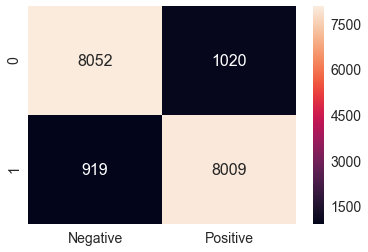

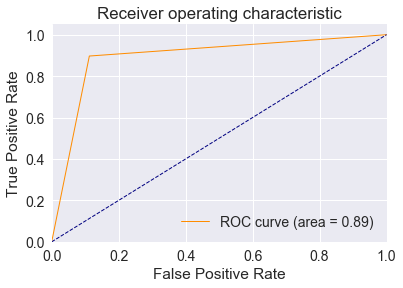

---------------------------------------------


In [31]:
models = LogisticRegressionClassifier(train_features = tfidf_X_tr, train_class = Y_train, \
                                     test_features = tfidf_X_test, test_class = Y_test, X_SearchCV = GridSearchCV, regularizations = ['l1'])

#### How accuracy changes with C for L1 regularization

In [32]:
models[0].grid_scores_

[mean: 0.78510, std: 0.00404, params: {'C': 0.001},
 mean: 0.88533, std: 0.00135, params: {'C': 0.01},
 mean: 0.88081, std: 0.00204, params: {'C': 0.1},
 mean: 0.87745, std: 0.00192, params: {'C': 1},
 mean: 0.87564, std: 0.00268, params: {'C': 10},
 mean: 0.84648, std: 0.00381, params: {'C': 100},
 mean: 0.81657, std: 0.00332, params: {'C': 1000}]

### Top 20 Words contributing to the Negative reviews for L1

In [34]:
(negative_features, positive_features) = GetImportantFeatures(models[0], tfidf_vectorizer)

In [35]:
negative_features.head(20)

,features,coefs
14587,disappoint,-0.454580
59483,worst,-0.285757
44169,return,-0.235803
52783,terribl,-0.230986
3182,aw,-0.197188
51500,tast,-0.186751
25927,horribl,-0.186002
3545,bad,-0.170360
34001,money,-0.158612
53706,thought,-0.156838


### Top 20 words contributing to Positive reviews for L1

In [36]:
positive_features.head(20)

,features,coefs
23999,great,0.555754
31229,love,0.414812
4761,best,0.389456
13759,delici,0.305623
39062,perfect,0.303353
25575,high recommend,0.293125
23153,good,0.270882
17885,excel,0.248371
18787,favorit,0.226579
35396,nice,0.192495


## Add noise to check for multi colinearity

In [37]:
from scipy.sparse import *
from scipy import *
import random

In [45]:
bow_X_tr_with_noise = bow_X_tr

In [46]:
bow_X_tr_with_noise.data += 0.01

-----------------------------l1--------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy = 88.84444444444445
F1 Score = 88.84816172386981
Precision = 88.11412205331571
Recall = 89.5945340501792


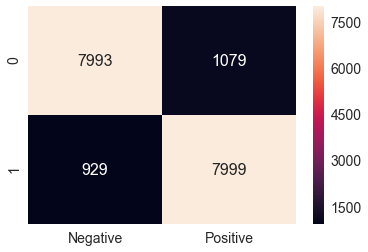

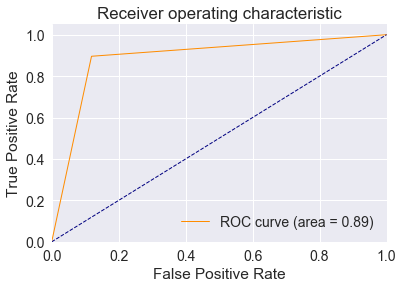

---------------------------------------------


In [48]:
models = LogisticRegressionClassifier(train_features = bow_X_tr_with_noise, train_class = Y_train, \
                                     test_features = bow_X_test, test_class = Y_test, X_SearchCV = GridSearchCV, regularizations = ['l1'])

In [49]:
models[0].grid_scores_

[mean: 0.77607, std: 0.00617, params: {'C': 0.001},
 mean: 0.88248, std: 0.00177, params: {'C': 0.01},
 mean: 0.88012, std: 0.00334, params: {'C': 0.1},
 mean: 0.87576, std: 0.00292, params: {'C': 1},
 mean: 0.87279, std: 0.00271, params: {'C': 10},
 mean: 0.84729, std: 0.00669, params: {'C': 100},
 mean: 0.81993, std: 0.00351, params: {'C': 1000}]

## W2V

In [60]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [55]:
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|-]',r' ',cleaned)
    return  cleaned

In [56]:
def Get_List_of_Sentences(cleanedText):
    list_of_sent=[]
    for sent in cleanedText:
        list_of_sent.append(cleanpunc(sent).split())
    return list_of_sent

In [57]:
def Get_Word2Vec_Vectors(list_of_sent):
    w2v_model = Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    return w2v_model

In [58]:
def GetAvgW2V_Vectors(list_of_sent, w2v_model):
    w2v_words = list(w2v_model.wv.vocab)
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    
    return sent_vectors

In [61]:
X_tr_listOfSent = Get_List_of_Sentences(X_train)
X_test_listOfSent = Get_List_of_Sentences(X_test)
X_tr_w2vModel = Get_Word2Vec_Vectors(X_tr_listOfSent)

In [62]:
# Get Average word2vec vector for each set of data -> Column standardize those vectors
avg_X_tr = GetAvgW2V_Vectors(X_tr_listOfSent, X_tr_w2vModel)
avg_X_test = GetAvgW2V_Vectors(X_test_listOfSent, X_tr_w2vModel)
(avg_X_tr, avg_X_test) = ColumnStandardization(avg_X_tr, avg_X_test)

In [63]:
def GetTfIdfW2V_Vectors(list_of_sent, w2v_model, final_tfidf):
    # TF-IDF weighted Word2Vec
    tfidf_feat = tfidf_vectorizer.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
    w2v_words = list(w2v_model.wv.vocab)
    print(f'number of sentences = {len(list_of_sent)}')
    for (row,sent) in enumerate(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if (word in w2v_words) and (word in tfidf_feat):
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = final_tfidf[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        print(f'Sentence number {row}', end = "\r")
    
    return tfidf_sent_vectors

In [64]:
# Get Average word2vec vector for each set of data -> Column standardize those vectors
avgtfidf_X_tr = GetTfIdfW2V_Vectors(X_tr_listOfSent, X_tr_w2vModel, tfidf_X_tr)

number of sentences = 42000


In [65]:
avgtfidf_X_test = GetTfIdfW2V_Vectors(X_test_listOfSent, X_tr_w2vModel, tfidf_X_test)
(avgtfidf_X_tr, avgtfidf_X_test) = ColumnStandardization(avgtfidf_X_tr, avgtfidf_X_test)

number of sentences = 18000


## Run classifier

-----------------------------l1--------------------------------------
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy = 83.88333333333333
F1 Score = 83.63328631875882
Precision = 84.25599636239627
Recall = 83.01971326164875


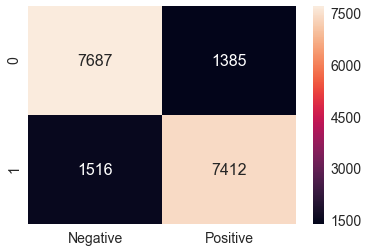

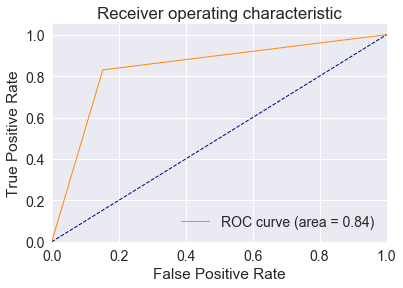

---------------------------------------------


In [66]:
models = LogisticRegressionClassifier(train_features = avg_X_tr, train_class = Y_train, \
                                     test_features = avg_X_test, test_class = Y_test, X_SearchCV = GridSearchCV, regularizations = ['l1'])

#### How accuracy changes with C for L1 regularization

In [67]:
models[0].grid_scores_

[mean: 0.81060, std: 0.00179, params: {'C': 0.001},
 mean: 0.83564, std: 0.00193, params: {'C': 0.01},
 mean: 0.83679, std: 0.00244, params: {'C': 0.1},
 mean: 0.83690, std: 0.00262, params: {'C': 1},
 mean: 0.83695, std: 0.00247, params: {'C': 10},
 mean: 0.83702, std: 0.00249, params: {'C': 100},
 mean: 0.83700, std: 0.00257, params: {'C': 1000}]

### Top 20 Words contributing to the Negative reviews for L1

In [68]:
def GetImportantFeatures(classifier):
    
    feature_names = np.array(X_tr_w2vModel.wv.vocab)
    names_coefs = np.vstack((feature_names, classifier.best_estimator_.coef_)).T

    df = pd.DataFrame(data = names_coefs, columns=['features','coefs'])
    df.sort_values(by=['coefs'],inplace=True, ascending=False)

    df[['coefs']] = df[['coefs']].apply(pd.to_numeric)

    df_positive = df[df.coefs > 0]

    df_negative = df[df.coefs < 0]

    df_positive.sort_values(by='coefs', ascending=False, inplace=True)
    df_negative.sort_values(by='coefs', ascending=True, inplace=True)
    
    return (df_negative, df_positive)

## Run Classifier

-----------------------------l1--------------------------------------
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy = 81.10000000000001
F1 Score = 80.73612684031711
Precision = 81.64223545579478
Recall = 79.84991039426524


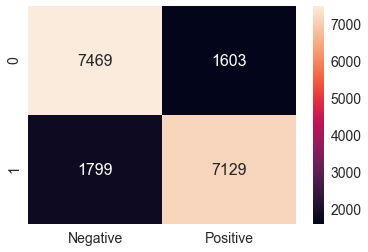

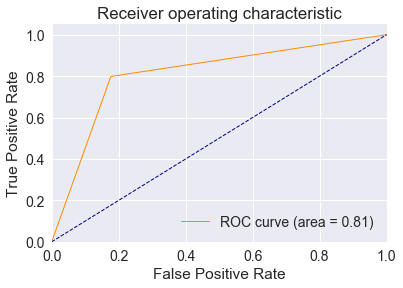

---------------------------------------------


In [83]:
models = LogisticRegressionClassifier(train_features = avgtfidf_X_tr, train_class = Y_train, \
                                     test_features = avgtfidf_X_test, test_class = Y_test, X_SearchCV = GridSearchCV, regularizations = ['l1'])

#### How accuracy changes with C for L1 regularization

In [84]:
models[0].grid_scores_

[mean: 0.78133, std: 0.00363, params: {'C': 0.001},
 mean: 0.80995, std: 0.00292, params: {'C': 0.01},
 mean: 0.81245, std: 0.00285, params: {'C': 0.1},
 mean: 0.81310, std: 0.00293, params: {'C': 1},
 mean: 0.81321, std: 0.00297, params: {'C': 10},
 mean: 0.81324, std: 0.00286, params: {'C': 100},
 mean: 0.81333, std: 0.00287, params: {'C': 1000}]

# Conclusion

1. L2 and L1 regularizations are spitting out approximately equal metrics(accuracy, recall etc.)
2. The best AUC is 0.89
3. Average w2v and tfidf w2v performed poorly
4. BOW and TFIDF featurization provided better results
5. The reason for w2v and tfidf w2v's poor performance is because of the the number of dimensions choosen (50)
6. After addition of noise there was no significant change in the coefficients and thus the features are not multi collinear